#### Intro to Neural Nets using OLS

This notebook will provide a gentle introduction to neural networks using a linear model. We will:

1. Create some data from a linear DGP
2. Run an OLS model
3. Recover the parameters using gradient descent, both from scipy and coded "by hand"
4. Write a simple neural network to approximate the model
5. Compare performance from each

This is being prepared for the JHU machine learning reading group. Suggestions and corrections are welcome.

First things first, let's create some dummy data. Our model will be:

$$
Y = \beta_0 + \beta_1 X + \beta_2 C + e
$$

Where $X$ is a continuous variable, $C$ is a binary variable, $e$ is a white noise error, and $\beta_0$ gives the intercept.

In [4]:
# Bring in necessary packages
import numpy as np
from scipy.stats import norm
import pandas as pd

import pandas as pd

# Set seed
np.random.seed(3112024)

# Generate 2 X variables uniformly distributed between -100 and 100
# Generate the X variable uniformly distributed between -100 and 100
X = np.random.uniform(-10, 10, (300, 1))

# Generate the categorical variable
C = np.random.choice([0, 1], size=(300, 1), p=[0.7, 0.3])

# Draw an error
e = norm.rvs(size=(300,1), scale = 2)

# set an intercept b0 and slopes b1 and b2
b0 = 10
b1= .85
b2 = 2

# Generate our Y variable
Y = b0 + b1*X + b2*C + e

# combine into a pandas data frame
data = pd.DataFrame({'I': np.ones(X.shape[0]), 'X': X.flatten(), 'C': C.flatten(), 'Y': Y.flatten()})


We will usually want to split our data into "training" and "validation" sets. The first is used to train the model, and the second to validate an out-of-sample fit. 

Go ahead and split up the data, using 80% of observations in the training sample and the remaining 20% as validation. Call the training data "train_data" and the validation data "val_data".

In [5]:
# size of training set:
train_size = round(0.8 * data.shape[0])

# size of validation set:
val_size   = data.shape[0] - train_size

# Get indices for the training set
indices = np.random.choice(range(0, data.shape[0]), size=train_size, replace=False)

# Use these indices to create the training set
train_data = data.loc[indices]

# Use the remaining indices for the validation set
val_data = data.drop(indices)

#### OLS Estimates

Our model is linear in two variables $X$ and $C$, with an intercept $\beta_0$. Let's use OLS on our training data to approximate the coefficients. 

In [6]:
# bring in package for OLS
# X variables:
X = train_data[['I','X', 'C']].values
# Y variable:
Y = train_data['Y'].values.reshape(-1, 1)

# Can do this manually:
# Calculate X transpose
X_T = X.T
# Calculate X transpose times X
X_T_X = np.dot(X_T, X)
# Calculate the inverse of X transpose times X
X_T_X_inv = np.linalg.inv(X_T_X)
# Calculate X transpose times X inverse times X transpose
X_T_X_inv_X_T = np.dot(X_T_X_inv, X_T)
# Calculate beta hat
beta_hat = np.dot(X_T_X_inv_X_T, Y)
# Print the estimated parameters
print(beta_hat)

# Or use a package:
import statsmodels.api as sm
OLS1 = sm.OLS(Y, X)
resultsOLS1 = OLS1.fit()

# save these coefficients:
OLS1coef = resultsOLS1.params

# Print the estimated parameters
print(resultsOLS1.summary())

[[9.78433348]
 [0.8699992 ]
 [2.15112902]]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     794.1
Date:                Thu, 14 Mar 2024   Prob (F-statistic):          8.74e-106
Time:                        16:11:25   Log-Likelihood:                -501.42
No. Observations:                 240   AIC:                             1009.
Df Residuals:                     237   BIC:                             1019.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

#### Normalization

In many numerical applications, an in particular with neural networks, our performance and accuracy will be improved by normalizing our data. In particular, if we would like to eventually use a function (such as the sigmoid) which is bound by 0 and 1, we will want to do a *min-max* normalization. Letting $\prime$ indicate the normalized data:

$$
X^{\prime} = \dfrac{X - \text{min}(X)}{\text{max}(X) - \text{min}(X)}
$$

If we apply this normalization to our model from above, letting $ r \equiv \text{max}(X) - \text{min}(X)$ and $ m \equiv \text{min}(X)$:

$$
Y - m = \beta_0 + \beta_1 X + \beta_2 C + e - m \\
(Y - m)*r  = (\beta_0 - m)*r + \beta_1 X*r + \beta_2 C*r + e*r \\
Y^{\prime} = \beta_0^{\prime} + \beta_1 X^{\prime}  + \beta_2 C^{\prime}  + e^{\prime} 

% Y * r = (\beta_0 + \beta_1 X + \beta_2 C + e)*r \\
% Y * r - m = (\beta_0* r - m) + \beta_1 X*r + \beta_2 C*r + e*r \\
% Y^{\prime} = \beta_0^{\prime} + \beta_1 X^{\prime}  + \beta_2 C^{\prime}  + e^{\prime} 
$$

So if we multiply our explanatory variables by $r$ and subtract out $m$, our estimates for $\beta_1$ and $\beta_2$ will be the same as before. But now when we include the new constant $\beta_0^{\prime}$, we will estimate some coefficient $b_0$ such that:

$$ b_0 * r(1 - m) = (\beta_0 - m)*r \\
\beta_0 = b_0 * (1-m) + m
$$

Let's normalize the data, and then check that OLS coefficients are the same as before.

In [7]:
# Normalize the data using the min-max of Y
# get the parameters for the normalization:
minY = np.min(Y)
maxY = np.max(Y)
rY  = maxY - minY

# normalize Y:
Yscaled = (Y - minY)/rY

# Now normalize our X data:
Xscaled = np.concatenate([(X[:,0] - minY).reshape(-1, 1), X[:,1:3]], axis=1) / rY

# And now check the OLS with the normalized data:
OLSscaled = sm.OLS(Yscaled, Xscaled)
OLSscaled = OLSscaled.fit()
print(OLSscaled.params)
OLSscaledparams = OLSscaled.params
# results2.params[2]- results2.params[2]*Ymean + Ymean
I = (OLSscaled.params[0]*(1 - minY) + minY)
print('Original OLS params are' , OLS1coef, 'and the transformed OLS params are', I, 'and', OLSscaledparams[1:3])


[6.77438807 0.8699992  2.15112902]
Original OLS params are [9.78433348 0.8699992  2.15112902] and the transformed OLS params are 9.7843334827413 and [0.8699992  2.15112902]


OK, so this all looks good.

Before we move to the Neural Net, let's try and estimate the parameterized, true model using a numerical technique: gradient descent (BFGS).

First, do this using the scipy "minimize" function. You will create a loss function for the sum of squared errors of the model at any given parameter vector, and then give the loss function to the minimization routine.

(Note: be careful everything is the right dimension!)

In [8]:
from jax import random
from scipy.optimize import minimize as spmin

# Write a loss function:
def loss_function(params, X, Y):
    # Calculate the predicted values
    Y_pred = np.dot(X, params)
    # Calculate the residuals
    residuals = Y - Y_pred
    # Return the sum of squared residuals
    return np.sum(residuals**2)

# Initialize your parameter vector to a random starting point and then plug into the minimization algorithm:
# Initialize parameters
key = random.PRNGKey(0)
params = random.normal(key, (3,))
result = spmin(loss_function, params, args=(Xscaled, Yscaled.squeeze()), method='BFGS')
print(result.x)

[6.77438764 0.86999934 2.15113056]


OK, so these are the same as what we had before (we won't bother to renormalize the intercept from here on; 1.09 is fine).

To better understand what is going on "under the hood", let's try and do this for ourselves. You should write two functions: first, a function which gives the gradient of our loss function. You can do this numerically, or call the "grad" function from Jax (this is what I will do, but note that you will need to recast the X and Y arrays as jax arrays, and rewrite the loss function using the jax version of the numpy commands). Then you should write a "step" function, which will update the parameters based on a "learning rate" which we specify. Remember, we want to move downhill towards the minimum!

In [9]:
# bring in our Jax libraries
import jax.numpy as jnp
from jax import grad

# First let's prepare our data for the Jax gradient function
X_jax = jnp.array(Xscaled, dtype=jnp.float32)
Y_jax = jnp.array(Yscaled, dtype=jnp.float32)

# then let's rewrite the loss function in Jax
def jax_loss_function(params, X, Y):
    # Calculate the predicted values
    Y_pred = jnp.dot(X, params)
    # Calculate the residuals
    residuals = Y - Y_pred
    # Return the sum of squared residuals
    return jnp.sum(residuals**2)

# First, define the gradient of the loss function using Jax
grad_objective_function = grad(jax_loss_function, argnums=0)

# test out the gradient:
grad_objective_function(params, X_jax, Y_jax)

# Now that we have a gradient, let's write our step function:
def gradient_descent_step(params, X, Y, learning_rate):
    # Calculate the gradient of the loss function
    grad_loss = grad_objective_function(params, X, Y)
    
    # Update the parameters
    params_new = params - learning_rate * grad_loss
    
    return params_new

# let's test it out:
key = random.PRNGKey(10)
params = random.normal(key, (3,))
onestep = gradient_descent_step(params, X_jax, Y_jax, learning_rate=1e-4)
print("Started at: ", params, "and took a step to:", onestep)

Started at:  [ 1.3471218 -1.0199504 -0.5627899] and took a step to: [ 1.6278843  -0.33417583 -0.50099456]


You can play around with the learning rate and see how the steps will change. Too small, and it will take a long time to converge, and we increase the possibility of getting trapped in a local minimum. Too large, and we will tend to overshoot. Smart algorithms (like BFGS) automatically adjust the step size as you go along. For our purposes here, let's just iterate a bit to see what happens, and then move on to the NN.

First, loop through the step function some predetermined amount of times:

In [10]:
# Set a starting place
key = random.PRNGKey(20)
params = random.normal(key, (3,))
og_params=params.copy()
for _ in range(500):
    params = gradient_descent_step(params, X_jax, Y_jax.squeeze(), learning_rate=1e-2)

print("new parameters: ", params, " compared to the starting values of:", og_params)
print("original loss was: ", jax_loss_function(og_params, X_jax, Y_jax), "and is now:", jax_loss_function(params, X_jax, Y_jax))

new parameters:  [6.79962   0.8700186 2.039927 ]  compared to the starting values of: [-1.2392296  -0.6280642   0.02767073]
original loss was:  20910.799 and is now: 5222.9185


We can lower the learning rate and see if we can get closer:

In [11]:
round1loss = jax_loss_function(params, X_jax, Y_jax)
round1params = params.copy()

for _ in range(500):
    params = gradient_descent_step(params, X_jax, Y_jax.squeeze(), learning_rate=1e-4)

print("Parameters from first round were: ", params, " compared to the starting values of:", round1params, "and to the OLS paramaters", OLSscaledparams)
print("Loss from first round were: ", round1loss, "and is now:", jax_loss_function(params, X_jax, Y_jax))


Parameters from first round were:  [6.7993817 0.8700186 2.0408807]  compared to the starting values of: [6.79962   0.8700186 2.039927 ] and to the OLS paramaters [6.77438807 0.8699992  2.15112902]
Loss from first round were:  5222.9185 and is now: 5223.0015


Pretty minimal improvement at this point. In reality, we should also randomize our starting points; gradient descent is always subject to getting stuck at local minima.

So far we just set a pre-determined number of iterations. But most algorithms will instead use a convergence criterion, and continue iterating until some target is met. Let's use the same step function and do this.

In [12]:
key = random.PRNGKey(19)
params = random.normal(key, (3,))
og_params = params.copy()

# and let's iterate until the change in the loss function is below some threshold
prev_loss = loss_function(params, Xscaled, Yscaled.squeeze())
change_threshold = 1e-6
while True:
    params = gradient_descent_step(params, Xscaled, Yscaled.squeeze(), learning_rate=1e-2)
    loss = loss_function(params, Xscaled, Yscaled.squeeze())
    if abs(prev_loss - loss) <= change_threshold:
        break
    prev_loss = loss
    # print(loss)

print("new parameters: ", params, " compared to the starting values of:", og_params, "and to the OLS paramaters", OLSscaledparams)


new parameters:  [6.760352  0.8699997 2.2099383]  compared to the starting values of: [-0.40682712 -0.24842586  0.63035905] and to the OLS paramaters [6.77438807 0.8699992  2.15112902]


It is a small step from gradient descent to estimate the parameters of a simple linear function to the Neural Net. Let's do a quick review of the basic neural net.

Neural Nets are just function approximators, using a highly flexible architecture. The neural net takes our data (explanatory variables $X$) and multiplies them by a vector of weights $w$ with an added bias (intercept) $b$. These are then fed into an activation function $f$. The output is our prediction. We use some kind of loss function to tell the network how close our estimate is to the true value, and then use gradient descent to update the weights and improve the prediction.

This is a description of a *shallow* neural network with one hidden layer; a *deep* neural network has multiple hidden layers, meaning there is at least one additional process of weighting and another function.

Let's create a shallow neural network to approximate our linear model. We will use the *sigmoid function* as our activation function:

$$
f(x) = \dfrac{1}{1 + exp(-x)}
$$

Since we will be taking derivatives, we will want to program the sigmoid function with its derivative. This can be written as $\sigma(x)(1-\sigma(x))x$.

Let's do this properly, and create a Python *class* called "NeuaralNetwork" which contains all of the functions we need.

In [13]:
# create a neural network class
class NeuralNetwork:
    # Initialize variables
    def __init__(self, X, Y):
        self.input      = X
        self.output     = Y
        # initialize weights for one hidden layer
        self.weights    = np.random.rand(self.input.shape[1],1) 
        # self.weights    = np.array([[.50], [.50], [.50]])
        self.error_history = []
        self.epoch_list = []

    # Activation function
    # let's use sigmoid, with the derivative built in
    def sigmoid(self, x, derivative=False):
        if derivative:
            return (1 / (1 + np.exp(-x)))*(1- (1 / (1 + np.exp(-x))))
        return 1 / (1 + np.exp(-x))
    
    # data move through the network: take the dot product of inputs and weights, then feed it into the sigmoid function
    def feed_forward(self):
        self.hidden = self.sigmoid(np.dot(self.input, self.weights))

    # then go backwards through the network to update weights
    def backpropagation(self):
        # error between prediction and actual
        self.error  = self.output - self.hidden
        delta = self.error * self.sigmoid(self.hidden, derivative=True)
        self.weights += np.dot(self.input.T, delta)

    # define a training function:
    def train(self, epochs=10000):
        for epoch in range(epochs):
            # flow forward and produce an output
            self.feed_forward()
            # go back though the network to make corrections based on the output -- eg gradient descent
            self.backpropagation()    
            # keep track of the error history over each epoch so we can track later
            self.error_history.append(np.average(np.abs(self.error)))
            self.epoch_list.append(epoch)
    
    # function to predict output                               
    def predict(self, new_input):
        # print(new_input)
        # print(self.weights)
        prediction = self.sigmoid(np.dot(new_input, self.weights))
        return prediction


Let's look a little more closely at what is happening in each update. We are choosing the weights $w$ to minimize the sum of squared errors:

$$
\text{min}_w \sum_{i=1}^{N} \dfrac{(\hat{y}_i - y_i)^2}{2} = \text{min}_w L
$$

so for weight $w_1$ (and switching to matrix notation) we have:

$$
\dfrac{\partial L}{\partial w_1} = \dfrac{\partial L}{\partial \hat{Y}} \dfrac{\partial \hat{Y}}{\partial \tilde{X}} \dfrac{\partial \tilde{X}}{\partial w_1} = (\hat{Y} - Y)*(\sigma(\tilde{X})(1-\sigma(\tilde{X})))*X
$$

Where $\tilde{X} = wX$.

Essentially, we get each observations' loss, and for each parameter we multiply the loss by the derivative for the relevant $X$ variable; this forms each observations' contribution to the update for each parameter as the sum (or average) of those terms.

Now let's instantiate the Neural Network and train it.

In [17]:
# create neural network   
NN = NeuralNetwork(Xscaled, Yscaled)
# train neural network
NN.train()

Now we'd like to check the fit of our extremely basic NN. There are different ways to do this: we can look at the SSE or MSE, or we can make a plot of all the errors.

The OLS MSE is 0.0908455933503512 and the NN SSE is 0.006274789177266982


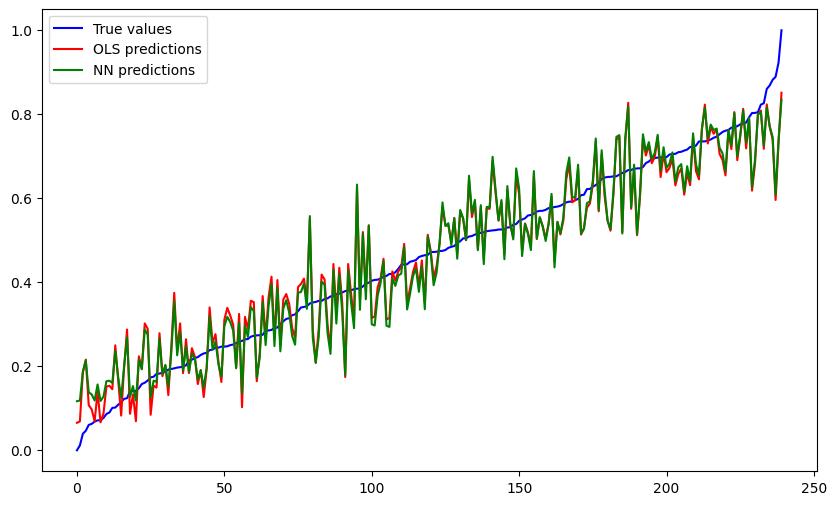

In [18]:
# bring in matplot lib
import matplotlib.pyplot as plt

# reshape X_scaled to have 2 dimensions
X_scaled_reshaped = Xscaled.reshape(-1, 3)
# calculate predictions from both models
OLSpred = np.dot(X_scaled_reshaped, OLSscaledparams)
NNpred  = NN.predict(Xscaled)
# calculate errors
OLSerror = OLSpred - Yscaled
NNerror = NNpred - Yscaled
# sum of squared errors
OLSSSE = np.sum(OLSerror**2)
NNSSE = np.sum(NNerror**2)
# mean squared error
ols_mse = np.mean(OLSerror**2)
nn_mse = np.mean(NNerror**2)

# now let's plot
data = pd.DataFrame({
    'Y_scaled': Yscaled.squeeze(),
    'OLSpred': OLSpred.squeeze(),
    'NNpred': NNpred.squeeze()
})

print("The OLS MSE is", ols_mse, "and the NN SSE is", nn_mse)

# Sort the data by Y_scaled
data.sort_values('Y_scaled', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Y_scaled'].values, 'b', label='True values')
plt.plot(data['OLSpred'].values, 'r', label='OLS predictions')
plt.plot(data['NNpred'].values, 'g', label='NN predictions')
plt.legend()
plt.show()

The basic NN performs well!

Not only did this example only use a single hidden layer (one dot product and one activation function), it only had one neuron, since we only took one product. Thus, this is the most simple neural network we can imagine: it's just a dot product inside a sigmoid function, rather than a dot product alone, as in our minimization above.

So we can now take a few next steps to make the NN richer:

1. Instead of including a constant in our data, add a *bias* term, a constant $b$ inside of the NN
2. Add more neurons (more sets of weights and activation functions, within the hidden layer)
3. Add another hidden layer (potentially with a different activation function)
4. Implement *stochastic gradient descent* or *minibatching*
5. Add some nonlinearity to the model, and see how the relative performance improves

The first two should improve the accuracy of the approximation, while the last should improve performance. We will work on these extensions in the next session.

g